In [1]:
import sys
import numpy as np
import os         
import matplotlib.pyplot as plt
%matplotlib inline

# for reading sound files.
from scipy.io import wavfile                          

# For training the neural network.
# Install pybrain. e.g. pip install pybrain.

from pybrain.datasets            import ClassificationDataSet
from pybrain.tools.shortcuts     import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules   import SoftmaxLayer
from pybrain.tools.xml.networkreader import NetworkReader
from pybrain.tools.xml.networkwriter import NetworkWriter

from pybrain.structure import FullConnection
from pybrain.structure import SigmoidLayer
from pybrain.structure import FeedForwardNetwork
from pybrain.structure import LinearLayer
from pybrain.structure import SoftmaxLayer
from pybrain.structure import TanhLayer

sq = lambda x: x*x

# A convenient time step.
deltaT = 0.2
lim1 = 5; lim2 = 305  # A good range of frequencies, for 16 kHz sampling.
noisy = 0.05   # We have a very clean speech sample!

def getData(fil):
  sampFreq, snd = wavfile.read(fil)
  snd = snd/2E15                         # put in range (-1,1)
  duration = snd.shape[0]/sampFreq
  numChunks = int(duration/deltaT)
  sizeChunk = int(len(snd)/numChunks)
  
  # Frequencies.
  freqs  = np.fft.rfftfreq(sizeChunk,deltaT)
  chunksF = []
  for lp in range(0,numChunks):    
    chunk = snd[lp*sizeChunk:(lp+1)*sizeChunk]      # get a chunk of speech.     
    chunksF.append(1E9*np.abs(np.fft.rfft(chunk)))  # take the fft,conveniently normalized.  

  mu = np.mean(chunksF)
  newMean = 0.
  ctr = 0
  for i in range(0,numChunks):
    for j in range(lim1,lim2):
      if abs(chunksF[i][j]) > noisy*mu:         # ignore silent portions.
        newMean += chunksF[i][j]
        ctr += 1

  # Delete portions of the sound file when the user is not speaking.
  mu = newMean/ctr
  zeros = []
  for lp in range(0,numChunks): 
    if np.mean(chunksF[lp]) < noisy*mu:  zeros.append(lp)

  data = []
  ctr = 0
  for i in range(0,numChunks):
    if i in zeros: continue         # silent part.
    tmp = []
    for j in range(lim1,lim2): tmp.append(chunksF[i][j])
    data.append(tmp)
  
  return data

def writeData(data,outFile):

  # Write the speech waveform to file, for plotting purposes.  
  l = len(data[0])
  f = open(outFile, "w")
  for i in range(0,len(data)):
    for j in range(0,l):
      f.write(str(i) + " " + str(j) + " " + str(data[i][j]) + "\n")
    f.write("\n")
  f.close()    


def getSamples(folders):

  # Each sound file is divided into a number of samples.
  samples = []
  for folder in folders:
    tmp = [v for v in os.listdir(folder) if v <> ".DS_Store"]
    samples.append(tmp)

  # Now samples[0] contains all the files for speaker 1,
  # samples[1] contains all the files for speaker 2, and so on.  
  speechSpeakers = []
  ctr = 0
  for sample in samples:
    speechSpeaker = []
    for file in sample:
      lsts = getData(folders[ctr]+file)
      for lst in lsts: speechSpeaker.append(lst)
    speechSpeakers.append(speechSpeaker)
    ctr += 1

  return speechSpeakers
      
def XY(speech,numFeatures,N):      
  
  tX = np.mat(np.zeros((N,numFeatures)))
  tY = []
  ctr = 0
  for i in range(0,len(speech)):
    for j in range(0,len(speech[i])):
      for k in range(0,numFeatures):
        tX[ctr,k] = speech[i][j][k]
      ctr += 1  
      tY.append(i)            
      
  return tX,tY
        

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#
# Data comes from the LibriSpeech ASR corpus
# http://www.openslr.org/12/
# File: train-clean-100.tar.gz [6.3G](training set of 100 hours "clean" speech) 
# I have converted flac files to wav files.
# 5 male speakers and 5 female speakers.
# Female speakers: 1,3,5,7,9
# Male speakers: 2,4,6,8,10
#  

trainingFoldersList = [    "samples/train/speaker1/",
                           "samples/train/speaker2/",
                           "samples/train/speaker3/",
                           "samples/train/speaker4/",
                           "samples/train/speaker5/",
                           "samples/train/speaker6/",
                           "samples/train/speaker7/",
                           "samples/train/speaker8/",
                           "samples/train/speaker9/",
                           "samples/train/speaker10/"                           
                        ]

tstFoldersList = [   "samples/test/speaker1/",
                     "samples/test/speaker2/",
                     "samples/test/speaker3/",
                     "samples/test/speaker4/",
                     "samples/test/speaker5/",
                     "samples/test/speaker6/",
                     "samples/test/speaker7/",
                     "samples/test/speaker8/",
                     "samples/test/speaker9/",
                     "samples/test/speaker10/"                     
                   ]

numSpeakers = 10
speech = getSamples(trainingFoldersList)  

In [3]:
N1 = 0; numFeatures = lim2-lim1
for idx in range(0,len(speech)):
  N1 += len(speech[idx])
trainX,trainY = XY(speech,numFeatures,N1)    

minArray = []; maxArray = []
for i in range(0,numFeatures):
  minArray.append(np.min(trainX[:,i]))
  maxArray.append(np.max(trainX[:,i]))    

f = open("min_max_values.dat", "w")
for i in range(0,numFeatures):
  f.write(str(maxArray[i]) + " " + str(minArray[i]) + "\n")
f.close()      
    
# Put training data in range (0,1)  
for i in range(0,N1):
  for j in range(0,numFeatures):
    trainX[i,j] = (trainX[i,j]-minArray[j])/(maxArray[j]-minArray[j])  
       
speech = getSamples(tstFoldersList)
N2 = 0; 
for idx in range(0,len(speech)):
  N2 += len(speech[idx])
  
tstX,tstY = XY(speech,numFeatures,N2)
for i in range(0,N2):
  for j in range(0,numFeatures):
    tstX[i,j] = (tstX[i,j]-minArray[j])/(maxArray[j]-minArray[j])  

trainLabels = np.mat(np.zeros((len(trainY),numSpeakers)))
tstLabels = np.mat(np.zeros((len(tstY),numSpeakers)))

for i in range(0,len(trainY)):
  for j in range(0,numSpeakers):
    if trainY[i] == j: trainLabels[i,j] = 1
    else: trainLabels[i,j] = 0

for i in range(0,len(tstY)):
  for j in range(0,numSpeakers):
    if tstY[i] == j: tstLabels[i,j] = 1
    else: tstLabels[i,j] = 0


In [4]:
# Test the classifier.
def tstClassifier(nn,tstX,tstY,ss):

  # Index corresponding to start of speaker 'n'
  limits = [0]  
  for lp in range(1,numSpeakers):
    for i in range(0,len(tstY)):
      if tstY[i] == lp:  break
    limits.append(i)
  limits.append(len(tstY))

  # Confusion matrix: Speaker 'm' predicted as speaker 'n'.
  confusion = np.mat(np.zeros((10,10)))  
  numS = {}
  answers = []  
  yes = 0; total = 0  
  step = ss
  for speaker in range(0,numSpeakers):
    for lp in range(limits[speaker],limits[speaker+1]-step,step):
      pred = []
      for x in range(lp,lp+step):
        A = [tstX[x,v] for v in range(0,numFeatures)]
        # Make a prediction.
        res = list(nn.activate(A))
        pred.append(res.index(np.max(res)))

      # There's a probability for every speaker. Let's pick the largest.  
      ctr = {}
      for v in pred:
        if v not in ctr: ctr[v] = 1
        else: ctr[v] += 1
      kys = ctr.keys()
      m = 0; best = 0
      for ky in kys:
        if ctr[ky] > m:
          m = ctr[ky]
          best = ky
    
      #Overall accuracy.
      if best == tstY[lp]: yes += 1
        
      # Confusion matrix. Speaker 'i' predicted to be speaker 'j'.  
      for r in range(0,10):
        if tstY[lp] == r: 
          if r not in numS: numS[r] = 1
          else: numS[r] += 1   
        for c in range(0,10):
          if tstY[lp] == r and best == c:
            confusion[r,c] += 1
          
      total += 1
    answers.append(yes*1./total)

  return answers,confusion,numS

In [5]:
#
# Now, we train the neural network.
#
numClasses = len(speech)
numHiddenNodes = 10     # Nodes per hidden layer.
numHiddenLayers = 5     # 5 layers.
possibleOutputs = 1     # Only 1 kind of output, i.e. each sample is one speaker.
numTrainingEpochs = 10  # Train 10 epochs.

trndata = ClassificationDataSet(numFeatures, possibleOutputs, nb_classes=numClasses)
ctr = 0
for row in range(0,N1):
  tempListOut = []; tempListIn = []
  tempListOut.append(int(trainY[row]))
  for i in range(0,numFeatures): 
    tempListIn.append(trainX[row,i])
    
  trndata.addSample(tempListIn,tempListOut)
trndata._convertToOneOfMany()

#first = True
first = False
outfolder = "networks/"    
nnFile = "nn49.xml" # Most recent.
st = 50

# For the first time, we need to create the neural network.
# After that, we just need to train.

if first:
  nn = FeedForwardNetwork()
  inputLayer = LinearLayer(numFeatures)
  nn.addInputModule(inputLayer)
  hiddenLayers = []
  for x in range(numHiddenLayers):
    hiddenLayer = SigmoidLayer(numHiddenNodes)
    nn.addModule(hiddenLayer)
    hiddenLayers.append(hiddenLayer)
  outputLayer = SoftmaxLayer(len(speech))
  nn.addOutputModule(outputLayer)
  
  inputConnection = FullConnection(inputLayer,hiddenLayers[0])
  outputConnection = FullConnection(hiddenLayers[numHiddenLayers-1],outputLayer)
  for x in range(numHiddenLayers-1):
    connect = FullConnection(hiddenLayers[x],hiddenLayers[x-1])
    nn.addConnection(connect)
  nn.addConnection(inputConnection)
  nn.addConnection(outputConnection)
  nn.sortModules()

else:  # We already have a network!
  nn = NetworkReader.readFrom(outfolder+nnFile)
    
trainer = BackpropTrainer(nn, dataset=trndata, momentum=0., verbose=True, weightdecay=0.)  
for i in range(numTrainingEpochs): 
  trainer.trainOnDataset(dataset=trndata)    
  if (i+1)%5 == 0:
    A,c,n = tstClassifier(nn,tstX,tstY,1)
    print np.mean(A)    
    # Save the network, to save time.
    NetworkWriter.writeToFile(nn, outfolder+"nn" + str(st)+".xml")     
    st += 1
    print i+1

Total error: 0.0143754296993
Total error: 0.0143496438709
Total error: 0.014343619139
Total error: 0.0143274169534
Total error: 0.0143549949778
0.756464269748
5
Total error: 0.0142992875205
Total error: 0.0143614479559
Total error: 0.0143196350162
Total error: 0.0143202247167
Total error: 0.014313238533
0.757600009599
10


In [6]:
# Performance on the test set, as a function of training epoch.
# We stop when we see signs of overfitting.
# On 0.2 seconds of data.
X = []; Y = []
for q in range(0,50):
  net = outfolder+"nn"+str(q)+".xml"
  nn = NetworkReader.readFrom(net)
  st = 1
  A,c,n = tstClassifier(nn,tstX,tstY,st)
  if q%5 == 0:
    print net,st*0.2,np.mean(A)
  X.append((q+1)*5)
  Y.append(np.mean(A))

networks/nn0.xml 0.2 0.499117365279
networks/nn5.xml 0.2 0.691663503931
networks/nn10.xml 0.2 0.721658134573
networks/nn15.xml 0.2 0.741639031398
networks/nn20.xml 0.2 0.727852097769
networks/nn25.xml 0.2 0.740176638619
networks/nn30.xml 0.2 0.74898643378
networks/nn35.xml 0.2 0.755489276652
networks/nn40.xml 0.2 0.740774548985
networks/nn45.xml 0.2 0.745473067619


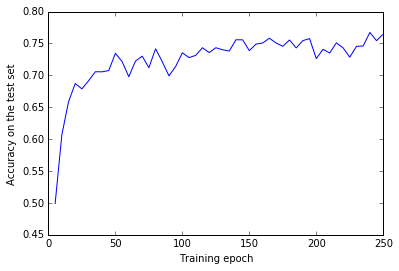

In [7]:
# Plot performance with training epoch, on 0.2 seconds of data.
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(X,Y)
plt.xlabel("Training epoch")
plt.ylabel("Accuracy on the test set")
plt.show()

In [8]:
# Performance on the test set, with 't' seconds of data,
# Accuracy for t = 0.2,0.4,0.6,0.8,1.0,... seconds.
net = "nn49.xml"
nn = NetworkReader.readFrom(outfolder+net)
X = []; Y = []
for st in range(1,26):
  A,c,n = tstClassifier(nn,tstX,tstY,st)
  print st*0.2,np.mean(A)
  X.append(st*0.2)
  Y.append(np.mean(A))

0.2 0.764805305461
0.4 0.789697890647
0.6 0.862283498213
0.8 0.887237110684
1.0 0.902481170611
1.2 0.920037707295
1.4 0.942073795735
1.6 0.946633467992
1.8 0.956715834479
2.0 0.955903690434
2.2 0.955550675976
2.4 0.967076487337
2.6 0.973441010539
2.8 0.979029237841
3.0 0.964161177113
3.2 0.968436822912
3.4 0.991153253831
3.6 0.990071200278
3.8 0.984173735962
4.0 0.984659795058
4.2 0.982023390668
4.4 0.981033772819
4.6 0.980199788274
4.8 0.977751442503
5.0 0.987732329963


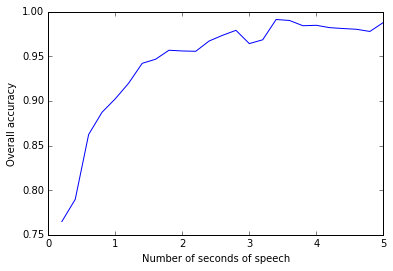

In [9]:
plt.plot(X,Y)
plt.xlabel("Number of seconds of speech")
plt.ylabel("Overall accuracy")
plt.show()

In [10]:
net = "nn49.xml"
nn = NetworkReader.readFrom(outfolder+net)
for st in [1,5,10]:
  A,c,n = tstClassifier(nn,tstX,tstY,st)
  # Columns are predictions.
  # First row: Speaker 0: Number of samples predicted as Speaker 0,1,2,. . .
  # First row: 515 samples of Speaker 0 predicted as Speaker 0, 2 samples predicted as Speaker 1, . . .
  # More likely to confuse 2 female speakers or 2 male speakers -
  # Columns 1,3,5,7,9 are female speakers, columns 2,4,6,8,10 are male speakers.
  print "With " + str(st*0.2) + " second(s) of speech"
  print c
  print "\n"[:-1]


With 0.2 second(s) of speech
[[ 515.    2.    3.    0.    1.    0.    0.    2.    4.    0.]
 [   2.  332.   17.   66.   35.   18.    5.   60.    1.   22.]
 [   2.   23.  312.    6.   54.    4.   61.    4.   43.    2.]
 [   2.   35.    7.  374.   33.    4.    3.    9.    1.   24.]
 [   6.    9.   26.    9.  486.    1.   34.   13.   19.    1.]
 [   0.   26.    3.    1.    1.  365.    4.   17.    0.   29.]
 [   0.   14.   50.    0.   59.    0.  378.    2.  100.    7.]
 [   1.   24.    4.   78.   23.   20.    0.  300.    0.   48.]
 [  16.    3.   32.    1.   47.    0.    7.    5.  489.    1.]
 [   0.   37.   11.   29.   15.   18.   32.   14.    8.  384.]]

With 1.0 second(s) of speech
[[ 105.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.   92.    0.   10.    2.    2.    0.    3.    1.    1.]
 [   0.    4.   81.    0.    8.    1.    3.    0.    5.    0.]
 [   0.    1.    0.   95.    1.    0.    0.    0.    0.    1.]
 [   0.    0.    2.    0.  113.    0.    2.    0.    3.   

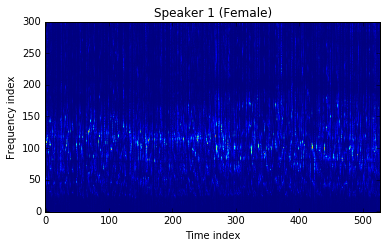

In [18]:
plt.xlabel("Time index")
plt.ylabel("Frequency index")
plt.title("Speaker 1 (Female)")
plt.imshow(np.matrix(speech[0]).T,origin="lower",aspect=1)

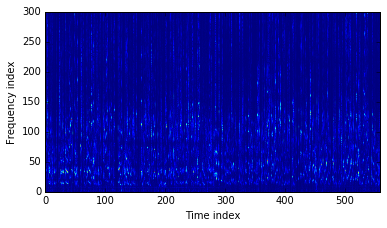

In [16]:
plt.xlabel("Time index")
plt.ylabel("Frequency index")
plt.title("Speaker 2 (Male)")
plt.imshow(np.matrix(speech[1]).T,origin="lower",aspect=1.)